# Instacart orders 

Exploratory data analysis of 
[3M Instacart orders](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)
[dataset](https://www.instacart.com/datasets/grocery-shopping-2017).

See also [data dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b).

In [1]:
import pandas as pd
import numpy as np
import glob
import os 
import matplotlib as plt
%matplotlib inline

DATASET_LOCATION = '../big_datasets/instacart_2017_05_01'


# Data prep

In [2]:
def load_data(path):
    """ Return a dictionary mapping each table (eg orders) to its df.
    """
    paths = glob.glob(os.path.join(path, "*.csv"))
    frames = {}
    
    for path in paths:
        df_name = path.split("\\")[-1][:-4] # without '.csv'
        if df_name == 'order_products__prior': # 500MB, skip it for now
            continue
        df = pd.read_csv(path, header=0)
        frames[df_name] = df
        
    return frames

frames = load_data(DATASET_LOCATION)

print('data frames available:') 
print(
    '\n'.join(
        '--- {} ---\nshape {}\ncolumns {}'.format(
            n, df.shape, list(df.columns)
        ) for n, df in frames.items()
    )
)


data frames available:
--- aisles ---
shape (134, 2)
columns ['aisle_id', 'aisle']
--- departments ---
shape (21, 2)
columns ['department_id', 'department']
--- orders ---
shape (3421083, 7)
columns ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
--- order_products__train ---
shape (1384617, 4)
columns ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
--- products ---
shape (49688, 4)
columns ['product_id', 'product_name', 'aisle_id', 'department_id']


In [3]:
# add some potentially useful columns
frames['orders']['order_hour_of_week'] = frames['orders']['order_dow'] * 24 + frames['orders']['order_hour_of_day']


# Ordering over time

- Customers seem to order mostly during daytime. 
- Hourly volume of orders is 25% higher in the weekend (assuming `order_dow` of zero means Saturday).
- Weekend customers also seem to be less frequent customers.


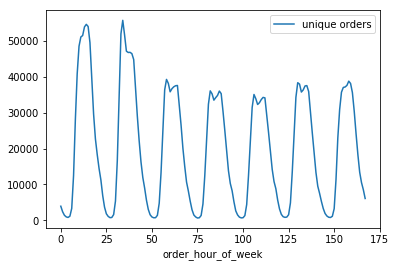

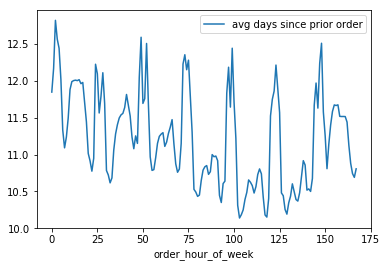

In [4]:
# histogram of orders by day of week + time of day
(
    frames['orders']
    .groupby('order_hour_of_week')
    .agg({'order_id':pd.Series.nunique})
    .rename({'order_id':'unique orders'}, axis='columns')
    .plot()
)

(
    frames['orders']
    .groupby('order_hour_of_week')
    .agg({'days_since_prior_order':np.mean})
    .rename({'days_since_prior_order':'avg days since prior order'}, axis='columns')
    .plot()
)

# Order diversity

Do customers typically order the same things, again and again?


In [5]:
# what % of customers with 2+ orders buy at least 1 product in 2+ orders?
frames['products'].head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# Top ordered products
What are they? Is it pizza?